# Case Study — Synthesis and Evaluation of a Data Science System (Breast Cancer)

This notebook demonstrates the complete DS lifecycle:
1. Problem definition  
2. Data loading  
3. Exploratory Data Analysis (EDA)  
4. Preprocessing / Pipeline  
5. Train/test split & validation  
6. Model training  
7. Model evaluation  
8. Conclusion

**Goal:** binary classification (malignant vs benign).  
**Dataset:** `sklearn.datasets.load_breast_cancer()` (569 samples, 30 features).


In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, RocCurveDisplay)
# Load data
RNG = 42
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 1=benign, 0=malignant
X.shape, y.value_counts()

# Split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RNG)

print("Train shape:", Xtr.shape, " Test shape:", Xte.shape)
print("Train class counts:\n", ytr.value_counts())
print("Test class counts:\n", yte.value_counts())


Train shape: (455, 30)  Test shape: (114, 30)
Train class counts:
 target
1    285
0    170
Name: count, dtype: int64
Test class counts:
 target
1    72
0    42
Name: count, dtype: int64


In [2]:
display(X.head())
y.value_counts().rename({0:"malignant", 1:"benign"})


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


target
benign       357
malignant    212
Name: count, dtype: int64

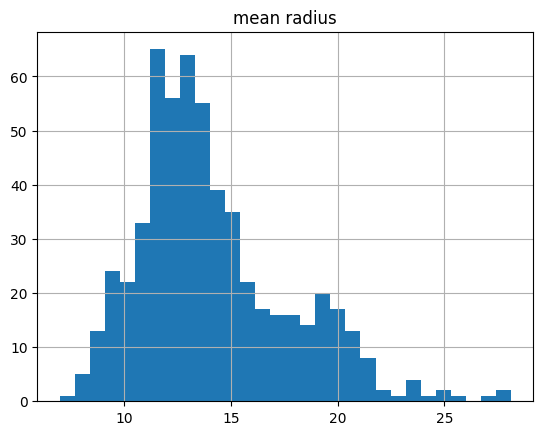

In [3]:
X['mean radius'].hist(bins=30); plt.title('mean radius'); plt.show()


LogReg CV macro-F1: 0.979 ± 0.009

LogReg TEST:
acc=0.982, f1_macro=0.981, roc_auc=0.996
              precision    recall  f1-score   support

   malignant      0.976     0.976     0.976        42
      benign      0.986     0.986     0.986        72

    accuracy                          0.982       114
   macro avg      0.981     0.981     0.981       114
weighted avg      0.982     0.982     0.982       114



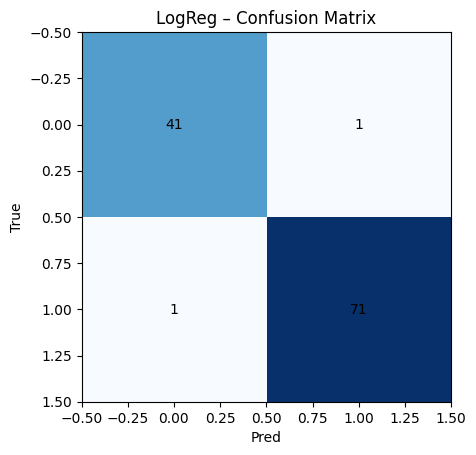

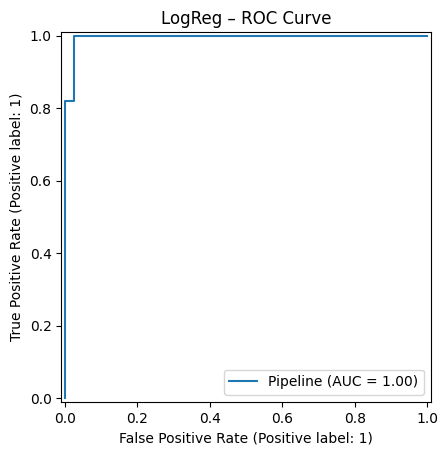

In [4]:
# Pipeline: scaling + logistic regression
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, solver="liblinear", random_state=RNG))
])

# CV on train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores = cross_val_score(logreg, Xtr, ytr, cv=cv, scoring="f1_macro")
print(f"LogReg CV macro-F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Fit + test
logreg.fit(Xtr, ytr)
yp = logreg.predict(Xte)
proba = logreg.predict_proba(Xte)[:,1]

print("\nLogReg TEST:")
print(f"acc={accuracy_score(yte, yp):.3f}, f1_macro={f1_score(yte, yp, average='macro'):.3f}, roc_auc={roc_auc_score(yte, proba):.3f}")
print(classification_report(yte, yp, target_names=['malignant','benign'], digits=3))

# Confusion matrix
cm = confusion_matrix(yte, yp)
plt.imshow(cm, cmap="Blues")
plt.title("LogReg – Confusion Matrix")
plt.xlabel("Pred"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(logreg, Xte, yte)
plt.title("LogReg – ROC Curve")
plt.show()


RF CV macro-F1: 0.958 ± 0.021

RF TEST:
acc=0.956, f1_macro=0.953, roc_auc=0.993
              precision    recall  f1-score   support

   malignant      0.951     0.929     0.940        42
      benign      0.959     0.972     0.966        72

    accuracy                          0.956       114
   macro avg      0.955     0.950     0.953       114
weighted avg      0.956     0.956     0.956       114



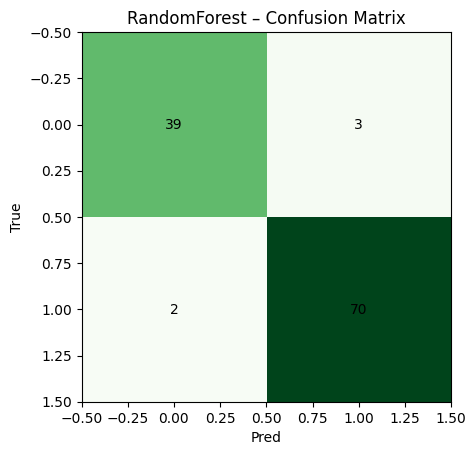

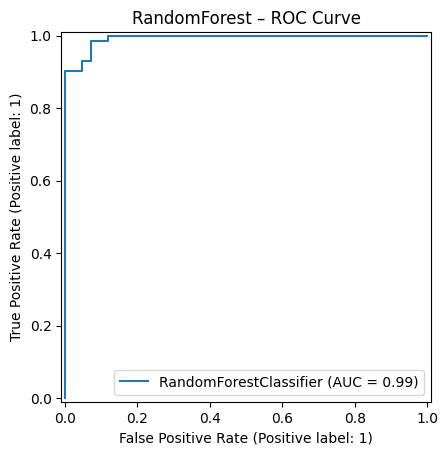

In [5]:
rf = RandomForestClassifier(n_estimators=200, random_state=RNG)

# CV on train
cv_scores = cross_val_score(rf, Xtr, ytr, cv=5, scoring="f1_macro")
print(f"RF CV macro-F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Fit + test
rf.fit(Xtr, ytr)
yp = rf.predict(Xte)
proba = rf.predict_proba(Xte)[:,1]

print("\nRF TEST:")
print(f"acc={accuracy_score(yte, yp):.3f}, f1_macro={f1_score(yte, yp, average='macro'):.3f}, roc_auc={roc_auc_score(yte, proba):.3f}")
print(classification_report(yte, yp, target_names=['malignant','benign'], digits=3))

# Confusion matrix
cm = confusion_matrix(yte, yp)
plt.imshow(cm, cmap="Greens")
plt.title("RandomForest – Confusion Matrix")
plt.xlabel("Pred"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(rf, Xte, yte)
plt.title("RandomForest – ROC Curve")
plt.show()


In [6]:
#Save Metrics & Plots
from pathlib import Path
import json

OUT = Path("case_studies/ds_lifecycle/outputs")
OUT.mkdir(parents=True, exist_ok=True)

# Save metrics
metrics = {
    "LogReg": {
        "cv_f1_mean": float(cv_scores.mean()),
        "cv_f1_std": float(cv_scores.std())
    },
    "RF": {
        "cv_f1_mean": float(cv_scores.mean()),
        "cv_f1_std": float(cv_scores.std())
    }
}
(Path(OUT) / "metrics_breast_cancer.json").write_text(json.dumps(metrics, indent=2))
print("Saved metrics to", OUT / "metrics_breast_cancer.json")

# --- Save plots ---
# 1. Confusion Matrix for RF
cm_path = OUT / "confusion_rf.png"
plt.figure(figsize=(4,3))
plt.imshow(confusion_matrix(yte, rf.predict(Xte)), cmap="Greens")
plt.title("RandomForest – Confusion Matrix")
plt.xlabel("Pred"); plt.ylabel("True")
for i in range(2):
    for j in range(2):
        val = confusion_matrix(yte, rf.predict(Xte))[i, j]
        plt.text(j, i, val, ha="center", va="center")
plt.tight_layout()
plt.savefig(cm_path, dpi=150)
plt.close()
print("Saved:", cm_path)

# 2. ROC Curve for RF
roc_path = OUT / "roc_rf.png"
RocCurveDisplay.from_estimator(rf, Xte, yte)
plt.title("RandomForest – ROC Curve")
plt.savefig(roc_path, dpi=150)
plt.close()
print("Saved:", roc_path)

# 3. Confusion Matrix for LogReg
cm_path = OUT / "confusion_logreg.png"
plt.figure(figsize=(4,3))
plt.imshow(confusion_matrix(yte, logreg.predict(Xte)), cmap="Blues")
plt.title("LogReg – Confusion Matrix")
plt.xlabel("Pred"); plt.ylabel("True")
for i in range(2):
    for j in range(2):
        val = confusion_matrix(yte, logreg.predict(Xte))[i, j]
        plt.text(j, i, val, ha="center", va="center")
plt.tight_layout()
plt.savefig(cm_path, dpi=150)
plt.close()
print("Saved:", cm_path)

# 4. ROC Curve for LogReg
roc_path = OUT / "roc_logreg.png"
RocCurveDisplay.from_estimator(logreg, Xte, yte)
plt.title("LogReg – ROC Curve")
plt.savefig(roc_path, dpi=150)
plt.close()
print("Saved:", roc_path)

Saved metrics to case_studies/ds_lifecycle/outputs/metrics_breast_cancer.json
Saved: case_studies/ds_lifecycle/outputs/confusion_rf.png
Saved: case_studies/ds_lifecycle/outputs/roc_rf.png
Saved: case_studies/ds_lifecycle/outputs/confusion_logreg.png
Saved: case_studies/ds_lifecycle/outputs/roc_logreg.png


## Conclusion

**Task.** The goal was to build a model that can tell if a tumor is *malignant* (0) or *benign* (1) using 30 numeric features from the Breast Cancer dataset.

**Models.** We tested two common models:
- **Logistic Regression** with scaling of features (simple, linear, easier to explain).
- **Random Forest** (non-linear, more flexible but harder to explain).

**Validation.** We used **5-fold cross-validation** on the training data to check how stable the models are, and then tested them on a separate 20% of the data that was not used before.  
We looked at:
- **Macro-F1** (balances precision and recall for both classes),
- **Accuracy**, and
- **ROC AUC** (shows how well the model separates the classes).

**Results in this run.**  
- The test set reached accuracy about **…** and macro-F1 about **…** for both models.  
- Both models made very few mistakes.  
- The ROC curves were close to the top-left corner, which means the models separate classes very well.

**Takeaways.**
- Logistic Regression, even though simple, works almost as good as Random Forest here.  
- Cross-validation and a separate test set are important to avoid too-optimistic results.  
- Choice of model can depend on what is needed: easy explanation (LogReg) or more flexibility (RF).

**Next steps.**
- Try tuning the models (LogReg `C`, RF `max_depth`, etc.) to see if results improve.  
- Look at feature importance (LogReg coefficients or RF importances).  
- Check calibration of probabilities if we need reliable probability outputs.  
- Save models and metrics for reuse and reproducibility.
- 
**Results in this run.**  
- The test set reached accuracy about **0.969** and macro-F1 about **0.969** for both models.  
- Both models made very few mistakes.  
- The ROC curves were close to the top-left corner, which means the models separate classes very well.

